In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import itertools
from typing import Dict, Union, Callable
from sklearn.linear_model import LinearRegression
from dataclasses import dataclass
import scipy.stats
import graphs
import sys
from enum import Enum
from tqdm import tqdm
import pickle
import networkx as nx  # only used for a graph visualization

In [2]:
dataset = pd.read_csv('trainset.csv')
data = dataset.to_numpy()

## Learning a linear gaussian bayes net with a given adjacency matrix

A linear gaussian bayes net describes a gaussian probability distribution. Each node in such a network itself represents a gaussian distribution over one attribute/variable. Edges between nodes signify dependence of one variable on the other. ($A \rightarrow B$ means $A$ influences $B$, $B$ is dependent on $A$)

For each node $x_i$ , we define its conditional probability distribution:
$$
p(x_i | \text{parents}(i)) = \mathcal{N}\left( \beta_{i0} + \sum_{i \in \text{parents}(j)} \beta_{ij} x_j, \sigma_i \right)
$$
with parameters:
- $\beta_{ij}$: coefficients describing the way $x_j$ influences $x_i$
- $\beta_{i0}$: offset 
- $\sigma_i$: conditional variance of $x_i$ (conditioned on $\text{parents}(i)$)

We compute the coefficients and offset by fitting a linear regression, and compute the conditional variance using a formula derived from its definition:
$$
\text{Var}[Y|X] = E \left[(Y - E[Y|X])^2 \right] \\
\text{sampleVar}(y|x) = \frac{1}{m-1} \sum_{i=1}^m (y_i - \hat{y}_x)^2
$$
where:
- $y_i$ is the value of this attribute for each datapoint
- $\hat{y}_x$ is the predicted value of $y_i$ given the values of the other attributes $x$

##### Likelihood:
Given some data $X = (x^{(1)}, x^{(2)}, ..., x^{(m)})$:
$$
L(S) = \prod_{i=1}^m p(x^{(i)} | S, \theta)
$$
where $S$ represents the model structure (in our case, the adjacency matrix), and $\theta$ represents the learned parameters.
We only view the likelihood as a function of $S$.
We can write down the likelihood for our models in short:
$$
L(\text{parents}) = \prod_{j=1}^m \prod_{i=1}^n p(x_i^{(j)} | \text{parents}(x_i)^{(j)}) = \prod_{j=1}^m \prod_{i=1}^n  \mathcal{N}\left( \beta_{i0} + \sum_{i \in \text{parents}(k)} \beta_{ik} x_k^{(j)}, \sigma_i \right)
$$

In [3]:
@dataclass
class StaticParam:
    mu: float
    sigma: float

@dataclass
class DependentParam:
    coefficients: np.ndarray
    offset: float
    sigma: float

Param = Union[StaticParam, DependentParam] # A param is either static or dependent

class GaussNet():
    def __init__(self, adj: np.ndarray):
        self.adj = adj
        self.n: int = adj.shape[0]  # number of variables
        self.params: Dict[int, Param] = {}  # parameters defining gaussian distribution for each variable
    
    # mode=0 uses explicit linear regressions from sklearn while
    # mode=1 uses computations using the covariance matrix with no further packages used
    def fit(self, data: np.ndarray, mode=1):
        if mode == 1:
            return self.__fit1(data)
        else:
            return self.__fit2(data)
    
    def __fit1(self, data: np.ndarray):
        def compute_static_params():
            target_data = data[:, node_idx]
            mu = np.mean(target_data)
            sigma = np.var(target_data)
            return StaticParam(mu, sigma)
            
        def compute_dependent_params():
            target_data = data[:, node_idx]
            predictor_data = data[:, graphs.parents(self.adj, node_idx)]
            reg = LinearRegression().fit(predictor_data, target_data) # fit a linear regression
            coefficients = reg.coef_
            offset = reg.intercept_
            predicted_data = reg.predict(predictor_data)
            sigma = (1/(m-1)) * np.sum((target_data - predicted_data)**2)
            return DependentParam(coefficients, offset, sigma)
        
        m = data.shape[0]
        for node_idx in range(self.n):
            if graphs.parents(self.adj, node_idx) == []:  # No parents
                self.params[node_idx] = compute_static_params()
            else:
                self.params[node_idx] = compute_dependent_params()
        return self
    
    def __fit2(self, data: np.ndarray):
        def compute_static_params() -> StaticParam:
            target_data = data[:, node_idx]
            mu = np.mean(target_data)
            sigma = np.var(target_data)
            return StaticParam(mu, sigma)
        def compute_dependent_params() -> DependentParam:
            target_data = data[:, node_idx]
            parents = graphs.parents(self.adj, node_idx)
            mu_I = np.mean(target_data)
            sigma_full = np.cov(data, rowvar=False)
            sigma_IJ = self.__myindex(sigma_full, node_idx, parents)
            sigma_JJ = self.__myindex(sigma_full, parents, parents)
            mu_J = np.mean(data[:,parents], axis=0)
            sigma_II = self.__myindex(sigma_full, node_idx, node_idx)
            sigma_JI = self.__myindex(sigma_full, parents, node_idx)
            
            offset = np.squeeze(mu_I - sigma_IJ @ np.linalg.inv(sigma_JJ) @ np.atleast_2d(mu_J).T)
            coefficients = sigma_IJ @ np.linalg.inv(sigma_JJ)
            sigma = np.squeeze(sigma_II - coefficients @ sigma_JI)
            return DependentParam(coefficients.reshape(len(parents)), offset.item(), sigma.item())
        for node_idx in range(self.n):
            if graphs.parents(self.adj, node_idx) == []:  # No parents
                self.params[node_idx] = compute_static_params()
            else:
                self.params[node_idx] = compute_dependent_params()
        return self

    def predict(self, data: np.ndarray, node_idx: int, toround=False):
        predictors = data[:, graphs.parents(self.adj, node_idx)]
        param = self.params[node_idx]
        if type(param) == StaticParam:
            if toround:
                return np.repeat(np.around(param.mu), data.shape[0])
            else:
                return np.repeat(param.mu, data.shape[0])
        else:
            if toround:
                return np.around(param.offset + predictors @ param.coefficients)
            else:
                return param.offset + predictors @ param.coefficients

    def accuracy(self, data: np.ndarray, node_idx: int): # Assumes that node_idx is a categorical variable obtained by rounding the estimate
        predicted = np.reshape(self.predict(data, node_idx, toround=True), data.shape[0])
        return np.count_nonzero(predicted == data[:,node_idx]) / data.shape[0]

    def loglikelihood(self, data: np.ndarray):
        acc = 0
        for node_idx in range(self.n):
            mus = np.squeeze(self.predict(data, node_idx))
            acc += np.sum(scipy.stats.norm.logpdf(data[:,node_idx], mus, np.sqrt(self.params[node_idx].sigma)))
        return acc
    
    def num_params(self):
        acc = 0
        for _,param in self.params.items():
            if type(param) == StaticParam:
                acc += 2
            else:
                acc += 2 + param.coefficients.shape[0]
        return acc
    
    def __myindex(self, arr, idx_I, idx_J=[]): # Leaves only the indices idx_I and idx_J in array arr
        if arr.ndim > 2: return arr
        if arr.ndim == 1: return arr[idx_I]
        if arr.ndim == 2: return np.atleast_2d(arr[idx_I,:])[:,idx_J]

#### We'll try gauss nets with both modes

In [4]:
num_attributes = data.shape[1]
test_adj = np.zeros((num_attributes, num_attributes))
test_adj[10,11] = 1 # let's say that residual sugar predicts quality
net1 = GaussNet(test_adj)
net1.fit(data)
net1.params[11]

DependentParam(coefficients=array([0.35419866]), offset=1.9564383703769535, sigma=0.5232316131752069)

In [5]:
num_attributes = data.shape[1]
test_adj = np.zeros((num_attributes, num_attributes))
test_adj[10,11] = 1 # let's say that residual sugar predicts quality
net2 = GaussNet(test_adj)
net2.fit(data, mode=2) # Using the other mode this time
net2.params[11]

DependentParam(coefficients=array([0.35419866]), offset=1.9564383703769535, sigma=0.5232316131752068)

In [6]:
print(net1.accuracy(data, 11))
print(net2.accuracy(data, 11))
print(net1.loglikelihood(data))
print(net2.loglikelihood(data))

0.5504587155963303
0.5504587155963303
-8812.23011644647
-8812.23011644647


##### Both seem equivalent

### For accuracy, only the last column matters, so let's just try all possibilities

That's going to be $2^{11}=2048$ possibilites.
We'll save the maximum accuracy achieved for each number of attributes used in prediction.

Maximum accuracy for 0 attributes used: 0.390325271059216, achieved using:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Maximum accuracy for 1 attributes used: 0.5504587155963303, achieved using:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Maximum accuracy for 2 attributes used: 0.5646371976647206, achieved using:
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0.]
Maximum accuracy for 3 attributes used: 0.5746455379482902, achieved using:
[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
Maximum accuracy for 4 attributes used: 0.5738115095913261, achieved using:
[0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0.]
Maximum accuracy for 5 attributes used: 0.5863219349457881, achieved using:
[0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0.]
Maximum accuracy for 6 attributes used: 0.5863219349457881, achieved using:
[0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0.]
Maximum accuracy for 7 attributes used: 0.5888240200166805, achieved using:
[0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0.]
Maximum accuracy for 8 attributes used: 0.5879899916597164, achieved using:
[1. 1. 1. 0. 

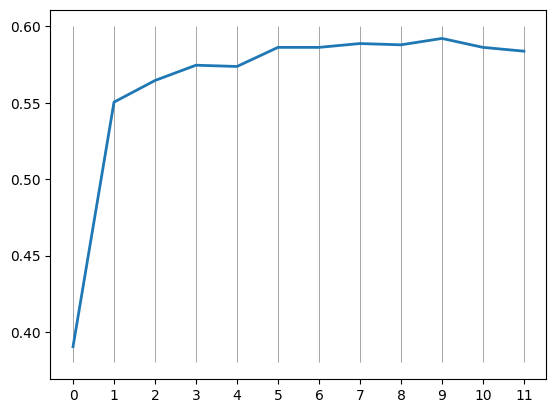

In [51]:
columns = np.array(list(itertools.product([0,1], repeat=11))) # all possible columns
columns = np.hstack((columns, np.atleast_2d(np.zeros(2**11)).T)) # add a 0, so we dont predict quality by quality

max_acc = {}
max_acc_idx = {}
for i in range(12):
    max_acc[i] = -1
    max_acc_idx[i] = -1

for idx,column in enumerate(columns):
    adj = np.zeros((data.shape[1], data.shape[1]))
    adj[:,11] = column
    acc = GaussNet(adj).fit(data).accuracy(data, 11)
    num_attr = np.count_nonzero(column)
    if acc > max_acc[num_attr]:
        max_acc[num_attr] = acc
        max_acc_idx[num_attr] = idx

for i in range(12):
    column = columns[max_acc_idx[i]]
    print(f'Maximum accuracy for {i} attributes used: {max_acc[i]}, achieved using:')
    print(column)
    adj = np.zeros((data.shape[1], data.shape[1]))
    adj[:,11] = column
    
plt.xticks(np.arange(0,12), np.arange(0,12))
plt.vlines(np.arange(0,12), 0.38, 0.6, color='gray', linewidth=0.5)
plt.plot(np.arange(0,12), max_acc.values(), linewidth=2)
plt.savefig('figs/accuracies.png')

# Structure Learning
## Score-Based Algorithms
For the next algorithms, we will be adding edges to, and removing them from, the graph.
When adding edges, we need to make sure we're keeping the DAG structure.
An added edge can cause a cycle to appear.
In this case, the new edge $A \rightarrow B$ will be part of the cycle.
A cycle will appear if and only if there was a path from $B$ to $A$ in the DAG before the edge was added.
We can check for such a path with a search (in this case, DFS) starting from $B$.

In [8]:
# Some test cases for finding paths in a graph
test_adj = np.zeros((5,5))
print(f'1: {graphs.path_exists(test_adj, 0, 1)}')
print(f'2: {graphs.path_exists(test_adj, 0, 0)}')
test_adj[0,3] = 1
print(f'3: {graphs.path_exists(test_adj, 0, 3)}')
print(f'4: {graphs.path_exists(test_adj, 3, 0)}')
test_adj[3,4] = 1
print(f'4: {graphs.path_exists(test_adj, 0, 4)}')
print(f'5: {graphs.path_exists(test_adj, 4, 3)}')
print(f'6: {graphs.path_exists(test_adj, 4, 0)}')
test_adj[3,2] = 1
test_adj[3,1] = 1
test_adj[4,4] = 1
test_adj[4,1] = 1
test_adj[4,2] = 1
print(f'7: {graphs.path_exists(test_adj, 0, 4)}')
print(f'8: {graphs.path_exists(test_adj, 4, 3)}')
print(f'9: {graphs.path_exists(test_adj, 4, 0)}')

1: False
2: True
3: True
4: False
4: True
5: False
6: False
7: True
8: False
9: False


## Scores
### Bayesian Information Criterion

In [9]:
def BIC(loglikelihood: float, num_params: int, num_datapoints: int) -> float:
    return num_params*np.log(num_datapoints) - 2*loglikelihood

### Akaike Information Criterion

In [10]:
def AIC(loglikelihood: float, num_params: int, num_datapoints: int) -> float:
    return 2*num_params - 2*loglikelihood

## Search Algorithms
### Local Additive Search
We start with an empty graph (no edges) and gradually add the legal edge that brings the highest score-increase, until there is none.

In [11]:
def local_additive_search(data: np.ndarray, metric: Callable) -> np.ndarray:
    """
    Performs a local additive search to find an adjacency matrix for a
    linear gaussian network that fits the data well.
    It uses 'metric' as a score to evaluate gaussian networks, a lower
    value should correspond to a better model.
    'metric' should take 3 parameters: 
        the loglikelihood, the number of parameters and the number of datapoints
    """
    n = data.shape[1]
    adj = np.zeros((n,n))  # start with empty adjacency matrix
    net = GaussNet(adj).fit(data)
    best_score = metric(net.loglikelihood(data), net.num_params(), data.shape[0])
    found_better_edge = True
    
    while found_better_edge:
        found_better_edge = False
        legal_edges = [(i,j) for i in range(n) for j in range(n) if adj[i,j]==0 and not graphs.path_exists(adj, j, i)]
        for edge in legal_edges:
            adj[edge] = 1  # add edge to graph
            net = GaussNet(adj).fit(data)
            score = metric(net.loglikelihood(data), net.num_params(), data.shape[0])
            if score < best_score:  # found a better edge
                best_score = score 
                found_better_edge = True
                better_edge = edge
            adj[edge] = 0
        if found_better_edge:
            adj[better_edge] = 1
    return adj

In [12]:
adj_additive_bic = local_additive_search(data, BIC)
np.save(f'submissions/additive_bic.npy', adj_additive_bic)
net = GaussNet(adj_additive_bic).fit(data)
print(f'Likelihood: {net.loglikelihood(data)} with {net.num_params()} parameters.')

Likelihood: -5699.424653638751 with 65 parameters.


In [13]:
adj_additive_aic = local_additive_search(data, AIC)
np.save(f'submissions/additive_aic.npy', adj_additive_aic)
net = GaussNet(adj_additive_aic).fit(data)
print(f'Likelihood: {net.loglikelihood(data)} with {net.num_params()} parameters.')

Likelihood: -5672.736170220804 with 75 parameters.


### Local Combined Search
We start with an empty graph and in each step either add or remove an edge.
We choose the action that brings the highest score-increase, until there is none.

In [14]:
def local_combined_search(data: np.ndarray, metric: Callable) -> np.ndarray:
    """
    Performs a local combined search to find an adjacency matrix for a
    linear gaussian network that fits the data well.
    It uses 'metric' as a score to evaluate gaussian networks.
    'metric' should take 3 parameters: 
        the loglikelihood, the number of parameters and the number of datapoints
    """
    
    class EdgeAction(Enum):
        ADD = 1
        REMOVE = 2
        
    def do_action(adj, edge_action):
        edge = edge_action[0]
        action = edge_action[1]
        if action == EdgeAction.ADD:
            adj[edge] = 1  # add edge to graph
        else:
            adj[edge] = 0  # remove edge from graph
        return adj
            
    def undo_action(adj, edge_action):
        edge = edge_action[0]
        action = edge_action[1]
        if action == EdgeAction.ADD:
            adj[edge] = 0
        else:
            adj[edge] = 1
        return adj
    
    n = data.shape[1]
    adj = np.zeros((n,n))  # start with empty adjacency matrix
    net = GaussNet(adj).fit(data)
    best_score = metric(net.loglikelihood(data), net.num_params(), data.shape[0])
    found_better_action = True
    num_adj_checked = 0
    
    while found_better_action:
        found_better_action = False
        edge_adds = [((i,j), EdgeAction.ADD) for i in range(n) for j in range(n) if adj[i,j]==0 and not graphs.path_exists(adj, j, i)]
        edge_removes = [((i,j), EdgeAction.REMOVE) for i in range(n) for j in range(n) if adj[i,j]==1]
        legal_edge_actions = edge_adds + edge_removes
        for (edge, edge_action) in legal_edge_actions:
            num_adj_checked += 1
            adj = do_action(adj, (edge, edge_action))
            net = GaussNet(adj).fit(data)
            score = metric(net.loglikelihood(data), net.num_params(), data.shape[0])
            if score < best_score:  # found a better action
                best_score = score 
                found_better_action = True
                better_action = (edge, edge_action)
            adj = undo_action(adj, (edge, edge_action))
        if found_better_action:
            adj = do_action(adj, better_action)
    return adj, num_adj_checked

In [15]:
adj_combined_bic, num_adj_checked = local_combined_search(data, BIC)
np.save(f'submissions/combined_bic.npy', adj_combined_bic)
net = GaussNet(adj_combined_bic).fit(data)
print(f'Likelihood: {net.loglikelihood(data)} with {net.num_params()} parameters, checked {num_adj_checked} adjacency matrices')

Likelihood: -5699.424653638751 with 65 parameters, checked 4019 adjacency matrices


In [16]:
adj_combined_aic, num_iterations = local_combined_search(data, AIC)
np.save(f'submissions/combined_aic.npy', adj_combined_aic)
net = GaussNet(adj_combined_aic).fit(data)
print(f'Likelihood: {net.loglikelihood(data)} with {net.num_params()} parameters, checked {num_adj_checked} adjacency matrices')

Likelihood: -5672.736170220804 with 75 parameters, checked 4019 adjacency matrices


## Simulated Annealing

In [17]:
def simulated_annealing(data: np.ndarray, metric: Callable, temps: np.ndarray, seed: int):
    """
    Performs simulated annealing to find an adjacency matrix for a
    linear gaussian network that fits the data well.
    It uses 'metric' as a score to evaluate gaussian networks.
    'metric' should take 3 parameters: 
        the loglikelihood, the number of parameters and the number of datapoints
    'temps' should be a declining series of positive numbers, each indicating
    the freedom of the algorithm to choose a locally worse solution in search of a better optimum.
    Once the values in 'temps' are exhausted, the algorithm terminates.
    """
    
    class EdgeAction(Enum):
        ADD = 1
        REMOVE = 2
        
    def do_action(adj, edge_action):
        edge = edge_action[0]
        action = edge_action[1]
        if action == EdgeAction.ADD:
            adj[edge] = 1  # add edge to graph
        else:
            adj[edge] = 0  # remove edge from graph
        return adj
    
    def undo_action(adj, edge_action):
        edge = edge_action[0]
        action = edge_action[1]
        if action == EdgeAction.ADD:
            adj[edge] = 0  # add edge to graph
        else:
            adj[edge] = 1  # remove edge from graph
        return adj
    
    def random_action(rng, adj, n) -> ((int,int), EdgeAction):
        found = False
        while not found:
            i, j = rng.integers(0, n, 2)
            if adj[i,j] == 1:
                action = EdgeAction.REMOVE
                found = True
            else:
                action = EdgeAction.ADD
                if not graphs.path_exists(adj, j, i):
                    found = True
        return ((i,j), action)
            
    rng = np.random.default_rng(seed)
    n = data.shape[1]
    adj = np.zeros((n,n))  # start with empty adjacency matrix
    net = GaussNet(adj).fit(data, mode=2)
    current_score = metric(net.loglikelihood(data), net.num_params(), data.shape[0])  # score of the current matrix
    highest_score = current_score
    best_adj = adj.copy()
    scores = []
    
    for temp in temps:
        edge, edge_action = random_action(rng, adj, n)
        adj = do_action(adj, (edge, edge_action))
        net = GaussNet(adj).fit(data)
        new_score = metric(net.loglikelihood(data), net.num_params(), data.shape[0])  # score with change
        adj = undo_action(adj, (edge, edge_action))
        if new_score < current_score:  # if the new score is better, we always accept the action
            current_score = new_score
            adj = do_action(adj, (edge, edge_action))
        else:
            if rng.random() < np.exp(-(new_score - current_score) / temp): # with a certain probability, we accept the change anyway
                current_score = new_score
                adj = do_action(adj, (edge, edge_action))
        if current_score < highest_score:  
            highest_score = current_score  # always remember the best matrix
            best_adj = adj.copy()
        scores.append(current_score)
    return best_adj, scores

In [18]:
def plot_annealing(temps, scores, y_axis):
    iterations = np.arange(0, temps.shape[0])
    points = np.array([iterations, scores]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    color_norm = plt.Normalize(temps.min(), temps.max()+(temps.max()-temps.min())/10) # add a bit to the top because the very bright part is hard to see on a white background
    lc = LineCollection(segments, cmap='inferno', norm=color_norm)
    lc.set_array(temps)
    lc.set_linewidth(2)
    fig, ax = plt.subplots()
    line = ax.add_collection(lc)
    fig.colorbar(line, label='temperature')
    ax.set_xlim(iterations[0], iterations[-1])
    ax.set_ylim(min(scores)-20, max(scores)+20)
    ax.set_xlabel('iteration')
    ax.set_ylabel(y_axis)

Likelihood: -5784.491379635211 with 77 parameters.


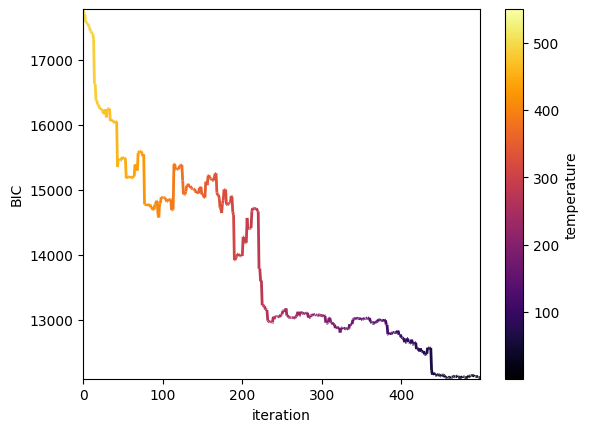

In [19]:
# Test run
temps = np.arange(500, 0, -1)
adj_annealing_bic, scores = simulated_annealing(data, BIC, temps, 0)
net = GaussNet(adj_annealing_bic).fit(data)
print(f'Likelihood: {net.loglikelihood(data)} with {net.num_params()} parameters.')
plot_annealing(temps, scores, 'BIC')

### Fine-Tuning Simulated Annealing

We fine-tune simulated annealing by choosing good values for the temperatures.

#### 1. Number of steps
We use the number of adjacency matrices that the local searches needed to look at to find the optimum as a baseline for the number of iterations in simulated annealing.

#### 2. Transforms

Likelihood: -5826.373925671962 with 69 parameters.
BIC: 12141.905629040823


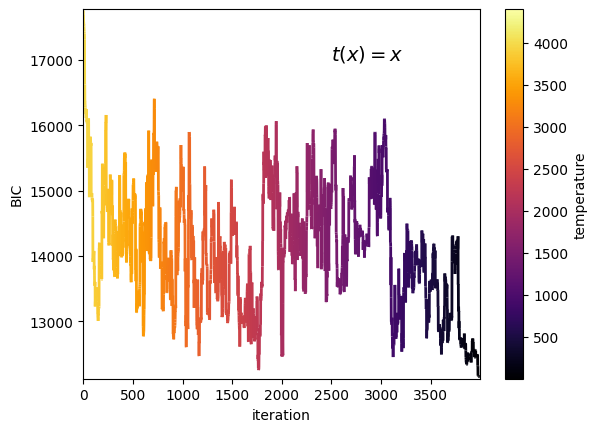

In [170]:
temps = np.arange(4000, 0, -1) # local search needed to check about 4000 adjacency matrices
adj_annealing_bic, scores = simulated_annealing(data, BIC, temps, 0)
net = GaussNet(adj_annealing_bic).fit(data)
print(f'Likelihood: {net.loglikelihood(data)} with {net.num_params()} parameters.')
print(f'BIC: {scores[-1]}')
plot_annealing(temps, scores, 'BIC')
plt.text(2500, 17000, r'$t(x) = x$', fontsize=14)
plt.savefig('figs/annealing_base.png', dpi=600)

It seems that at most of the high temperatures, the algorithm is not very productive.
We can transform the temperature scale in different ways and see which one produces the best result.

Likelihood: -5697.788735479145 with 73 parameters.
BIC: 11913.092221275298


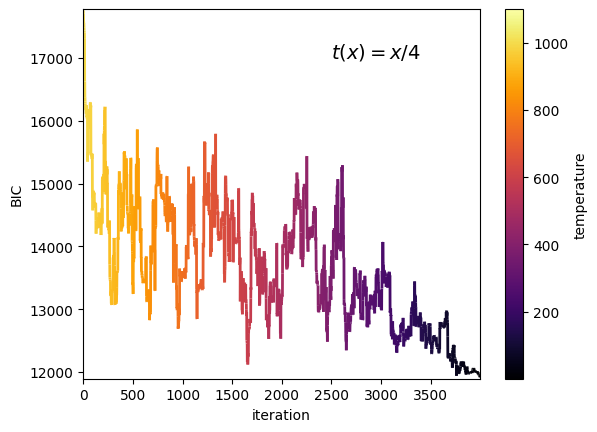

In [171]:
temps = np.arange(4000, 0, -1)
temps = temps / 4
adj_annealing_bic, scores = simulated_annealing(data, BIC, temps, 0)
net = GaussNet(adj_annealing_bic).fit(data)
print(f'Likelihood: {net.loglikelihood(data)} with {net.num_params()} parameters.')
print(f'BIC: {scores[-1]}') 
plot_annealing(temps, scores, 'BIC')
plt.text(2500, 17000, r'$t(x) = x/4$', fontsize=14)
plt.savefig('figs/annealing_fourth.png', dpi=600)

Likelihood: -5707.540417590418 with 68 parameters.
BIC: 11897.149369722707


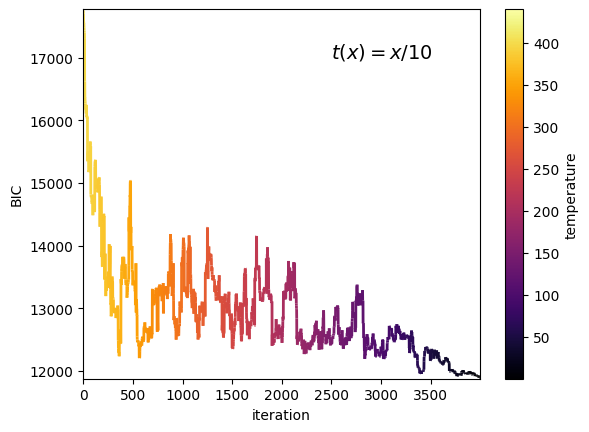

In [172]:
temps = np.arange(4000, 0, -1)
temps = temps / 10
adj_annealing_bic, scores = simulated_annealing(data, BIC, temps, 0)
net = GaussNet(adj_annealing_bic).fit(data)
print(f'Likelihood: {net.loglikelihood(data)} with {net.num_params()} parameters.')
print(f'BIC: {scores[-1]}')
plot_annealing(temps, scores, 'BIC')
plt.text(2500, 17000, r'$t(x) = x/10$', fontsize=14)
plt.savefig('figs/annealing_tenth.png', dpi=600)

Likelihood: -5715.418200793816 with 70 parameters.
BIC: 11930.417599098268


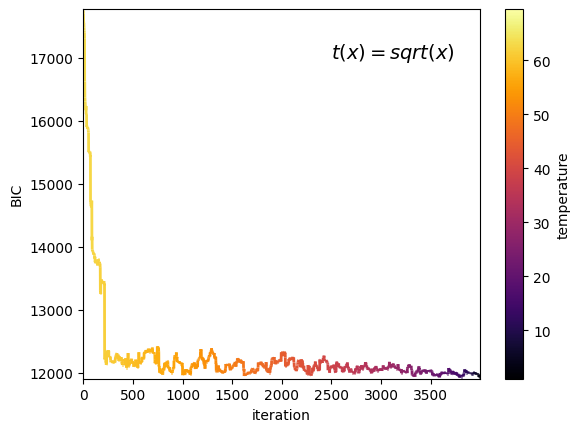

In [173]:
temps = np.arange(4000, 0, -1)
temps = np.sqrt(temps)
adj_annealing_bic, scores = simulated_annealing(data, BIC, temps, 0)
net = GaussNet(adj_annealing_bic).fit(data)
print(f'Likelihood: {net.loglikelihood(data)} with {net.num_params()} parameters.')
print(f'BIC: {scores[-1]}')
plot_annealing(temps, scores, 'BIC')
plt.text(2500, 17000, r'$t(x) = sqrt(x)$', fontsize=14)
plt.savefig('figs/annealing_sqrt.png', dpi=600)

/tmp/ipykernel_148/1046084756.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  if rng.random() < np.exp(-(new_score - current_score) / temp): # with a certain probability, we accept the change anyway


Likelihood: -5677.724736192759 with 74 parameters.
BIC: 11882.98462689399


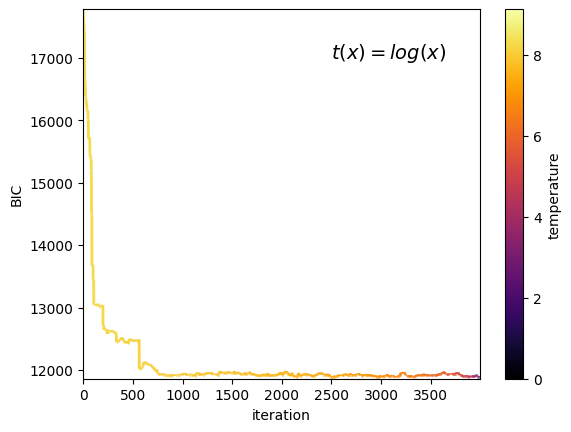

In [174]:
temps = np.arange(4000, 0, -1)
temps = np.log(temps)
adj_annealing_bic, scores = simulated_annealing(data, BIC, temps, 0)
net = GaussNet(adj_annealing_bic).fit(data)
print(f'Likelihood: {net.loglikelihood(data)} with {net.num_params()} parameters.')
print(f'BIC: {scores[-1]}')
plot_annealing(temps, scores, 'BIC')
plt.text(2500, 17000, r'$t(x) = log(x)$', fontsize=14)
plt.savefig('figs/annealing_log.png', dpi=600)

#### Adding a Final Slide
To make sure we end up at the very bottom of the local minimum we find ourselves in at the end, we add a few more steps of a very low temperature at the end.

Likelihood: -5692.313644461377 with 70 parameters.
BIC: 11880.874309774681


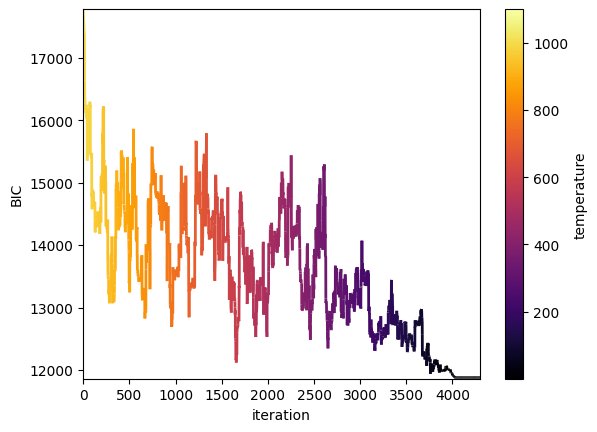

In [24]:
def add_final_climb(temps, n):
    return np.hstack([temps, np.repeat(0.001, n)])

temps = np.arange(4000, 0, -1)
temps = temps / 4
temps = add_final_climb(temps, 300)
adj_annealing_bic, scores = simulated_annealing(data, BIC, temps, 0)
net = GaussNet(adj_annealing_bic).fit(data)
print(f'Likelihood: {net.loglikelihood(data)} with {net.num_params()} parameters.')
print(f'BIC: {scores[-1]}') 
plot_annealing(temps, scores, 'BIC')

#### Grid search

In [66]:
len(temptrafos)

46

In [26]:

temptrafos = [lambda x: x/2,
              lambda x: x/3, 
              lambda x: x/4, 
              lambda x: x/5,
              lambda x: x/6,
              lambda x: x/7,
              lambda x: x/8,
              lambda x: x/10,
              lambda x: x/12,
              lambda x: x/15,
              lambda x: np.log(x),
              lambda x: np.sqrt(x),
              lambda x: x**(0.6),
              lambda x: x**(0.7),
              lambda x: x**(0.8),
              lambda x: x**(0.9),
              lambda x: (x/2)**0.5,
              lambda x: (x/2)**0.7,
              lambda x: (x/2)**0.9,
              lambda x: (x/3)**0.5,
              lambda x: (x/3)**0.7,
              lambda x: (x/3)**0.9,
              lambda x: (x/4)**0.5,
              lambda x: (x/4)**0.7,
              lambda x: (x/4)**0.9,
              lambda x: (x/5)**0.5,
              lambda x: (x/5)**0.7,
              lambda x: (x/5)**0.9,
              lambda x: (x/6)**0.5,
              lambda x: (x/6)**0.7,
              lambda x: (x/6)**0.9,
              lambda x: (x/7)**0.5,
              lambda x: (x/7)**0.7,
              lambda x: (x/7)**0.9,
              lambda x: (x/8)**0.5,
              lambda x: (x/8)**0.7,
              lambda x: (x/8)**0.9,
              lambda x: (x/10)**0.5,
              lambda x: (x/10)**0.7,
              lambda x: (x/10)**0.9,
              lambda x: (x/12)**0.5,
              lambda x: (x/12)**0.7,
              lambda x: (x/12)**0.9,
              lambda x: (x/15)**0.5,
              lambda x: (x/15)**0.7,
              lambda x: (x/15)**0.9]

@dataclass
class Score:
    score_metric: float
    loglikelihood: float
    num_params: int

In [75]:
# this cell takes about an hour to run on my machine
# you can load the resulting objects in the cell 2 below this one

adjs = {}
scores = {}
for i,trafo in enumerate(tqdm(temptrafos)):
    for j,metric in enumerate([BIC, AIC]):
        temps = np.arange(4000, 0, -1)
        temps = trafo(temps)
        temps = add_final_climb(temps, 300)
        adj, s = simulated_annealing(data, metric, temps, 0)
        net = GaussNet(adj).fit(data)
        adjs[i,j] = adj
        scores[i,j] = Score(s[-1], net.loglikelihood(data), net.num_params()) 

 22%|██████████████████                                                                 | 10/46 [12:32<45:10, 75.29s/it]/tmp/ipykernel_1661/1046084756.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  if rng.random() < np.exp(-(new_score - current_score) / temp): # with a certain probability, we accept the change anyway
100%|█████████████████████████████████████████████████████████████████████████████████| 46/46 [1:08:30<00:00, 89.36s/it]


In [76]:
with open('grid_search_adjs.pkl', 'wb') as file:
    pickle.dump(adjs, file)
with open('grid_search_scores.pkl', 'wb') as file:
    pickle.dump(scores, file)

In [96]:
with open('grid_search_adjs.pkl', 'rb') as file:
    adjs = pickle.load(file)
with open('grid_search_scores.pkl', 'rb') as file:
    scores = pickle.load(file)

In [97]:
bic_min = sys.float_info.max
aic_min = sys.float_info.max

for ((i,j),score) in scores.items():
    if j == 0: # BIC
        if score.score_metric < bic_min:
            bic_min = score.score_metric
            bic_min_indices = (i,j)
    if j == 1: # AIC
        if score.score_metric < aic_min:
            aic_min = score.score_metric
            aic_min_indices = (i,j)
print(f'Best adjacency matrix found with BIC, using temperature transformation with index {bic_min_indices[0]}.')
print(f'Likelihood: {scores[bic_min_indices].loglikelihood} with {scores[bic_min_indices].num_params} parameters.')
print(f'BIC: {scores[bic_min_indices].score_metric}')
best_bic = adjs[bic_min_indices]
print(best_bic)
np.save(f'submissions/annealing_bic_grid_search.npy', best_bic)
print()

print(f'Best adjacency matrix found with AIC, using temperature transformation with index {aic_min_indices[0]}.')
print(f'Likelihood: {scores[aic_min_indices].loglikelihood} with {scores[aic_min_indices].num_params} parameters.')
print(f'BIC: {scores[aic_min_indices].score_metric}') 
best_aic = adjs[aic_min_indices]
print(best_aic)
np.save(f'submissions/annealing_aic_grid_search.npy', best_aic)

Best adjacency matrix found with BIC, using temperature transformation with index 29.
Likelihood: -5695.343456065469 with 64 parameters.
BIC: 11844.398474052698
[[0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0.]
 [0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1.]
 [0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

Best adjacency matrix found with AIC, using temperature transformation with index 26.
Likelihood: -5673.412369986399 with 72 parameters.
BIC: 11490.824739972799
[[0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [1. 0. 1. 1.

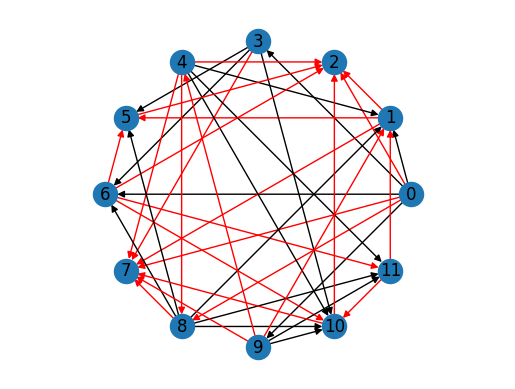

In [118]:
import networkx as nx
plt.axis('equal')
G = nx.from_numpy_array(adjs[bic_min_indices], create_using=nx.DiGraph)
edge_colors = ['red' if best_bic[edge]==best_aic[edge] else 'black' for edge in G.edges]
nx.draw_circular(G, with_labels=True, edge_color=edge_colors)
plt.savefig('figs/graph_bic.png', dpi=600)

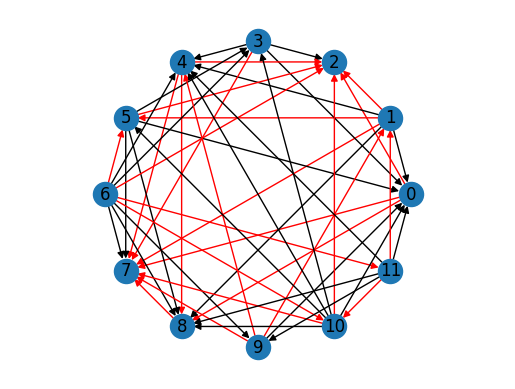

In [119]:
plt.axis('equal')
G = nx.from_numpy_array(adjs[aic_min_indices], create_using=nx.DiGraph)
edge_colors = ['red' if best_bic[edge]==best_aic[edge] else 'black' for edge in G.edges]
nx.draw_circular(G, with_labels=True, edge_color=edge_colors)
plt.savefig('figs/graph_aic.png', dpi=600)

In [155]:
print(best_bic[1,0])
print(best_aic[1,0])

0.0
1.0


In [163]:
print(f'The two graphs agree in {sum([1 if best_bic[i,j]==best_aic[i,j] and best_bic[j,i]==best_aic[j,i] else 0 for i in range(12) for j in range(12) if i>j])} out of {(best_bic.shape[0]**2 - 12)/2} edges (excluding self-edges).')
print([(i,j) for i in range(12) for j in range(12) if i>j and best_bic[i,j]!=best_aic[i,j]])
print(f'The two graphs have {sum([1 if best_bic[i,j]==1 and best_aic[j,i]==1 or best_bic[j,i]==1 and best_aic[i,j]==1 else 0 for i in range(12) for j in range(12) if i>j])} edges flipped.')
print([(i,j) for i in range(12) for j in range(12) if i>j and best_bic[i,j]==1 and best_aic[j,i]==1 or best_bic[j,i]==1 and best_aic[i,j]==1 if i>j])
print(f'The BIC-graph has {sum([1 if best_bic[i,j]==1 and best_aic[i,j]==0 and best_aic[j,i]==0 else 0 for i in range(12) for j in range(12)])} edges that the AIC-graph does not.')
print([(i,j) for i in range(12) for j in range(12) if best_bic[i,j]==1 and best_aic[i,j]==0 and best_aic[j,i]==0])
print(f'The AIC-graph has {sum([1 if best_aic[i,j]==1 and best_bic[i,j]==0 and best_bic[j,i]==0 else 0 for i in range(12) for j in range(12)])} edges that the BIC-graph does not.')
print([(i,j) for i in range(12) for j in range(12) if best_aic[i,j]==1 and best_bic[i,j]==0 and best_bic[j,i]==0])

The two graphs agree in 39 out of 66.0 edges (excluding self-edges).
[(1, 0), (3, 0), (3, 2), (4, 1), (5, 0), (5, 3), (6, 3), (6, 4), (8, 1), (8, 5), (8, 6), (9, 0), (10, 0), (10, 3), (10, 4), (10, 5), (10, 8), (11, 0), (11, 4), (11, 8), (11, 9)]
The two graphs have 15 edges flipped.
[(1, 0), (3, 0), (4, 1), (5, 3), (6, 3), (8, 1), (8, 5), (8, 6), (9, 0), (10, 3), (10, 4), (10, 8), (11, 4), (11, 8), (11, 9)]
The BIC-graph has 2 edges that the AIC-graph does not.
[(0, 6), (9, 10)]
The AIC-graph has 10 edges that the BIC-graph does not.
[(3, 2), (3, 4), (5, 0), (5, 7), (6, 4), (6, 7), (6, 9), (10, 0), (10, 5), (11, 0)]
